# going deeper02
### augment에 대해 공부해보고 특히 cutmix와 mixup aumentatin 기법을 공부해보자.

In [2]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5MDOE6/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5MDOE6/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


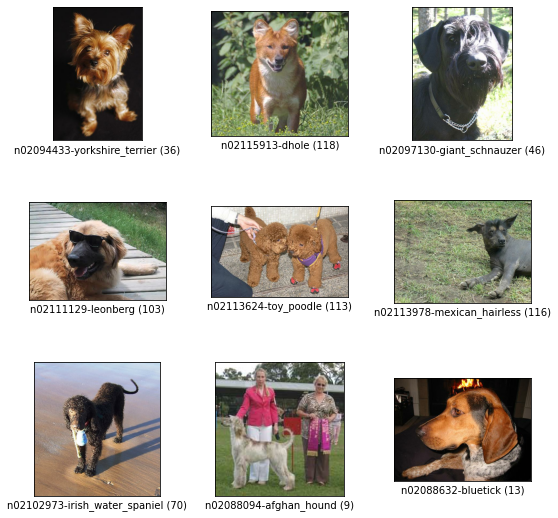

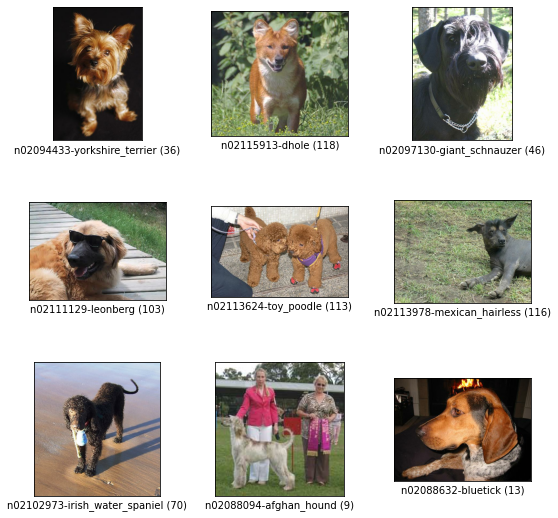

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

### 데이터 augment적용
### 나는 총 네가지 모델을 만들것이다.  기본적인 augmetation기법을 사용한것, cutmix 기법을 사용한것, mix up 기법을 사용한것, 세가지 전부다 사용한것, 이렇게 총 네가지 모델을 만들어 비교해 볼것이다.

### 데이터 리사이즈 함수

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### 기본적인 augmentation 함수

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### cutmix 함수

In [8]:
def get_clip_box(image_a, image_b, img_size=224):

    x = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    y = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    
    
    width = 120
    
   
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [9]:

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:

def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = 0.3

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [11]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### mixup 함수

In [12]:

def mixup_2_images(image_a, image_b, label_a, label_b):
  
    a = 0.5
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [13]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### one hot 함수

In [14]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

### Augmentation을 적용한 데이터셋 만드는 함수

In [27]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
    
    

### 데이터구성

In [28]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [29]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_all_aug = apply_normalize_on_dataset(ds_train, with_mixup=True,with_aug=True,with_cutmix=True)
ds_test2 = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

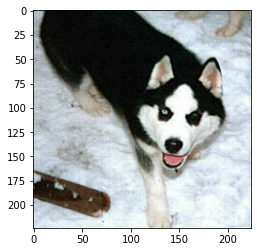

In [110]:
for data, _ in ds_train_no_aug.take(1):
  data = data[0]

plt.imshow(data)

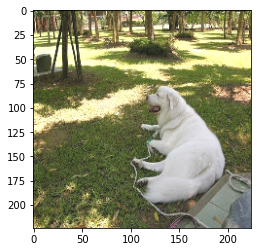

In [55]:
for data, _ in ds_train_aug.take(1):
  data = data[0]

plt.imshow(data)

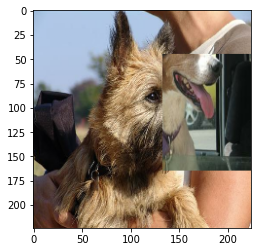

In [90]:
for data, _ in ds_train_cutmix.take(1):
  data = data[0]

plt.imshow(data)

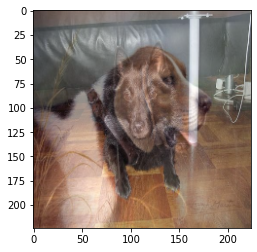

In [91]:
for data, _ in ds_train_mixup.take(1):
  data = data[0]

plt.imshow(data)

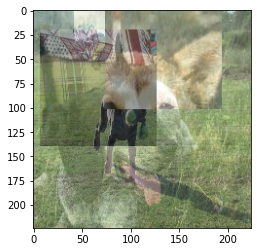

In [92]:
for data, _ in ds_train_all_aug.take(1):
  data = data[0]

plt.imshow(data)

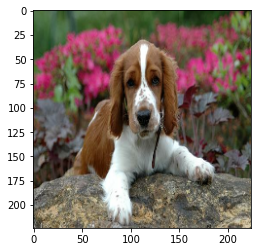

In [75]:
for data, _ in ds_test.take(1):
  data = data[0]

plt.imshow(data)

### 모델 다섯개 만들기

In [30]:
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [31]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [32]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [33]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [34]:
all_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


### 학습 진행

In [35]:
EPOCH = 20

no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 2.1892 - accuracy: 0.4522 - val_loss: 3.4801 - val_accuracy: 0.1875
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.6831 - accuracy: 0.8143 - val_loss: 1.0167 - val_accuracy: 0.7001
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 0.1860 - accuracy: 0.9665 - val_loss: 0.9183 - val_accuracy: 0.7317
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0487 - accuracy: 0.9967 - val_loss: 0.8939 - val_accuracy: 0.7403
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0207 - accuracy: 0.9997 - val_loss: 0.9104 - val_accuracy: 0.7395
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9205 - val_accuracy: 0.7415
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9355 - val_ac

In [64]:
EPOCH = 20

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 110s 120ms/step - loss: 2.2873 - accuracy: 0.4297 - val_loss: 2.7913 - val_accuracy: 0.3096
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.9473 - accuracy: 0.7314 - val_loss: 1.6094 - val_accuracy: 0.5589
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.5413 - accuracy: 0.8474 - val_loss: 1.2871 - val_accuracy: 0.6353
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2712 - accuracy: 0.9333 - val_loss: 1.0448 - val_accuracy: 0.7027
Epoch 5/20
750/750 [==============================] - 90s 119ms/step - loss: 0.2005 - accuracy: 0.9530 - val_loss: 1.0621 - val_accuracy: 0.7032
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 0.1471 - accuracy: 0.9697 - val_loss: 0.9919 - val_accuracy: 0.7236
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0698 - accuracy: 0.9890 - val_loss: 0.9358 - val_accuracy: 0.

In [97]:
EPOCH = 20

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test2,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 106s 128ms/step - loss: 4.1057 - accuracy: 0.1657 - val_loss: 3.9093 - val_accuracy: 0.1341
Epoch 2/20
750/750 [==============================] - 96s 128ms/step - loss: 3.2713 - accuracy: 0.3819 - val_loss: 1.5500 - val_accuracy: 0.5934
Epoch 3/20
750/750 [==============================] - 96s 127ms/step - loss: 2.9724 - accuracy: 0.4895 - val_loss: 1.3937 - val_accuracy: 0.6237
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 2.7622 - accuracy: 0.5641 - val_loss: 1.4390 - val_accuracy: 0.6216
Epoch 5/20
750/750 [==============================] - 96s 128ms/step - loss: 2.6000 - accuracy: 0.6032 - val_loss: 1.3353 - val_accuracy: 0.6511
Epoch 6/20
750/750 [==============================] - 95s 127ms/step - loss: 2.5017 - accuracy: 0.6386 - val_loss: 1.2694 - val_accuracy: 0.6589
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 2.3647 - accuracy: 0.6870 - val_loss: 1.4534 - val_a

In [98]:
EPOCH = 20

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test2,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 128ms/step - loss: 4.3947 - accuracy: 0.0727 - val_loss: 3.7989 - val_accuracy: 0.1311
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 3.8211 - accuracy: 0.1554 - val_loss: 1.9350 - val_accuracy: 0.4653
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 3.5981 - accuracy: 0.2017 - val_loss: 1.7262 - val_accuracy: 0.5189
Epoch 4/20
750/750 [==============================] - 95s 126ms/step - loss: 3.3993 - accuracy: 0.2396 - val_loss: 1.4996 - val_accuracy: 0.5744
Epoch 5/20
750/750 [==============================] - 96s 128ms/step - loss: 3.2677 - accuracy: 0.2590 - val_loss: 1.4905 - val_accuracy: 0.5949
Epoch 6/20
750/750 [==============================] - 96s 127ms/step - loss: 3.1266 - accuracy: 0.3015 - val_loss: 1.4377 - val_accuracy: 0.6000
Epoch 7/20
750/750 [==============================] - 97s 129ms/step - loss: 3.0335 - accuracy: 0.3084 - val_loss: 1.7203 - val_accuracy: 0.

In [36]:
EPOCH = 20

all_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_all_aug = all_aug_resnet50.fit(
    ds_train_all_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test2,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 109s 131ms/step - loss: 4.8376 - accuracy: 0.0127 - val_loss: 6.8600 - val_accuracy: 0.0119
Epoch 2/20
750/750 [==============================] - 97s 130ms/step - loss: 4.6983 - accuracy: 0.0332 - val_loss: 3.4770 - val_accuracy: 0.1824
Epoch 3/20
750/750 [==============================] - 94s 126ms/step - loss: 4.5698 - accuracy: 0.0555 - val_loss: 2.7544 - val_accuracy: 0.3032
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 4.4737 - accuracy: 0.0828 - val_loss: 2.4278 - val_accuracy: 0.3572
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 4.4020 - accuracy: 0.1014 - val_loss: 2.0748 - val_accuracy: 0.4598
Epoch 6/20
750/750 [==============================] - 94s 126ms/step - loss: 4.3432 - accuracy: 0.1146 - val_loss: 1.9054 - val_accuracy: 0.4990
Epoch 7/20
750/750 [==============================] - 97s 130ms/step - loss: 4.2891 - accuracy: 0.1394 - val_loss: 1.8431 - val_a

In [39]:
import pickle
with open('history.pickle', 'rb') as f:
  history_resnet50_aug = pickle.load(f)
with open('history2.pickle', 'rb') as f:
  history_resnet50_cutmix = pickle.load(f)
with open('history3.pickle', 'rb') as f:
  history_resnet50_mixup = pickle.load(f)

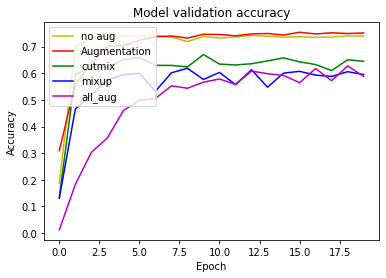

In [40]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.plot(history_resnet50_all_aug.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no aug','Augmentation', 'cutmix','mixup','all_aug'], loc='upper left')
plt.show()

### 음 솔직히 기본적인 augmentation만 적용하는게 성능이 가장 좋았다. cutmix나 mixup을 쓰는것이 더 안좋은 결과를 초래한것같다. 그리고 cutmix,기본적인augmentation,mixup을 섞은것은 mixup보다는 조금 더 향상된 결과를 보여줬다. 하지만 그렇게 차이는 나지는 않는것같고 내 생각엔 그냥 기본적인 augmentation을 사용하는게 가장 좋은것같다. 이것으로 goingdeeper02를 마친다.